### Task 1 - Create data set 

In [573]:
import numpy as np
from scipy.integrate import solve_ivp

# Define the Lorenz system
def lorenz(t, xyz, sigma, r, b):
    x, y, z = xyz
    dxdt = -sigma*x + sigma*y
    dydt = -x*z + r*x - y
    dzdt = x*y - b*z
    return [dxdt, dydt, dzdt]

# Set the parameters
sigma = 10
r = 28
b = 8/3

# Set the initial conditions and time span
t0, tf = 0, 100
x0 = [1, 1, 1]
t_span = [t0, tf]

# Define the time step and the number of steps
dt = 0.01
t_steps = int((tf - t0) / dt) + 1

# Solve the system using the fourth-order Runge-Kutta method
sol = solve_ivp(lorenz, t_span, x0, t_eval=np.linspace(t0, tf, t_steps), args=(sigma, r, b))

Y = sol.y
nComp = np.shape(Y[1])
print(np.shape(Y)[1])
print(nComp)

10001
(10001,)


### Task 2

In [574]:
class Reservoir:
    def __init__(self, input_size, nReservoirNeurons, sigma, Y):
        self.n = input_size
        self.N = nReservoirNeurons
        self.sigma = sigma
        self.Y = Y
        self.T = Y.shape[1]
        self.w_in = np.random.normal(loc=0, scale=np.sqrt(1/self.N), size=(self.N, self.n))
        self.w_reserv = self.get_reservoir_weights()
        
    def get_reservoir_weights(self):
        sparsity = 0.1
        dense_w = np.random.normal(loc=0, scale=np.sqrt(self.sigma), size=(self.N, self.N))
        frac = int(self.N*self.N*sparsity)
        indices = np.random.choice(self.N*self.N, frac, replace=False)
        
        row_indices = indices // self.N  # convert 1D indices to 2D row indices
        col_indices = indices % self.N   # convert 1D indices to 2D column indices
        sparse_w = np.zeros((self.N, self.N))
        
        sparse_w[row_indices, col_indices] = dense_w[row_indices, col_indices]
        return sparse_w
        
    def g(self, local_field):
        return np.tanh(local_field)
    
    
    def compute_reservoir_states(self, ridge):
        r = np.zeros(self.N)
        R = np.zeros((self.N, self.T))
        
        for t in range(self.T-1):
            reservoir_field = np.dot(self.w_reserv, r)
            input_field = np.dot(self.w_in, self.Y[:,t])
            r = self.g(reservoir_field + input_field)
            R[:, t] = r
            
        I = np.identity(self.N)
        self.w_out = np.dot(np.dot(self.Y, R.T), np.linalg.inv(np.dot(R, R.T) + ridge * I))
        
    def predict(self, x0):
        x = x0
        r = np.zeros(self.N)
        y = np.zeros((self.n, self.T))
        y[:,0] = x0
        for t in range(self.T-1):
            reservoir_field = np.dot(self.w_reserv, r)
            input_field = np.dot(self.w_in, x)
            r = self.g(reservoir_field + input_field.reshape(self.N))
            y[:, t+1] = np.dot(self.w_out, r)
            x = y[:, t+1]
        return y
    
    
    def compute_error(self, y_test):
        y_pred = self.predict(self.Y[:, 0])
        mse = np.mean((y_test - y_pred)**2)
        return mse
    
    def maximal_singular_value(self):
        _, s, _ = np.linalg.svd(self.w_reserv)
        return np.max(s)
        

### Test

In [575]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluate(n_iterations, sigmas):
    n_samples = len(sigmas)
    mse = np.zeros((2, n_samples))
    sing_vals = np.zeros((2, n_samples))
    
    for i, sigma in enumerate(tqdm(sigmas)):
        for _ in range(n_iterations):
            model_3D = Reservoir(3, nReservoirNeurons, sigma, Y)
            model_1D = Reservoir(1, nReservoirNeurons, sigma, x2)                     
            model_3D.compute_reservoir_states(ridge)
            model_1D.compute_reservoir_states(ridge)
                              
            mse[0, i] += model_3D.compute_error(Y) / n_iterations  # Averaging over the iterations
            mse[1, i] += model_1D.compute_error(Y) / n_iterations  # Averaging over the iterations
                              
            sing_vals[0, i] += model_3D.maximal_singular_value() / n_iterations  # Averaging over the iterations
            sing_vals[1, i] += model_1D.maximal_singular_value() / n_iterations  # Averaging over the iterations
                              
    plt.plot(sing_vals[0,:], mse[0,:] , '-o', label='3D')
    plt.plot(sing_vals[1,:], mse[1,:] , '-o', label='1D')                        
    plt.xscale("log")
    plt.xlabel('Maximal Singular Value')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.27s/it]


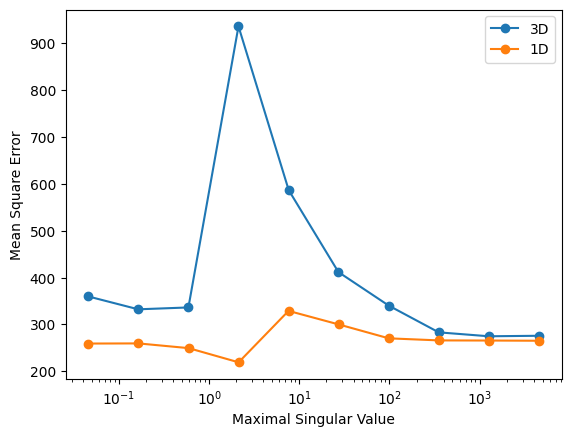

In [576]:
n_iterations = 5
sigmas = np.logspace(-5, 5, num=10)
evaluate(n_iterations, sigmas)

## ------------------------------

In [220]:
#Parameters
nReservoirNeurons = 500
sigma = 0.2
ridge = 0.01

temp = Y[1,:]
x2 = temp.reshape((1, Y.shape[1]))

# Create the reservoir object and compute the reservoir states
reservoir_3D = Reservoir(3, nReservoirNeurons, sigma, Y)
reservoir_3D.compute_reservoir_states(ridge)

reservoir_1D = Reservoir(1, nReservoirNeurons, sigma, x2)
reservoir_1D.compute_reservoir_states(ridge)

pred_3D = reservoir_3D.predict(x0)
pred_1D = reservoir_1D.predict(x0[1])

t_span = np.linspace(t0, tf, int((tf - t0) / dt) + 1)


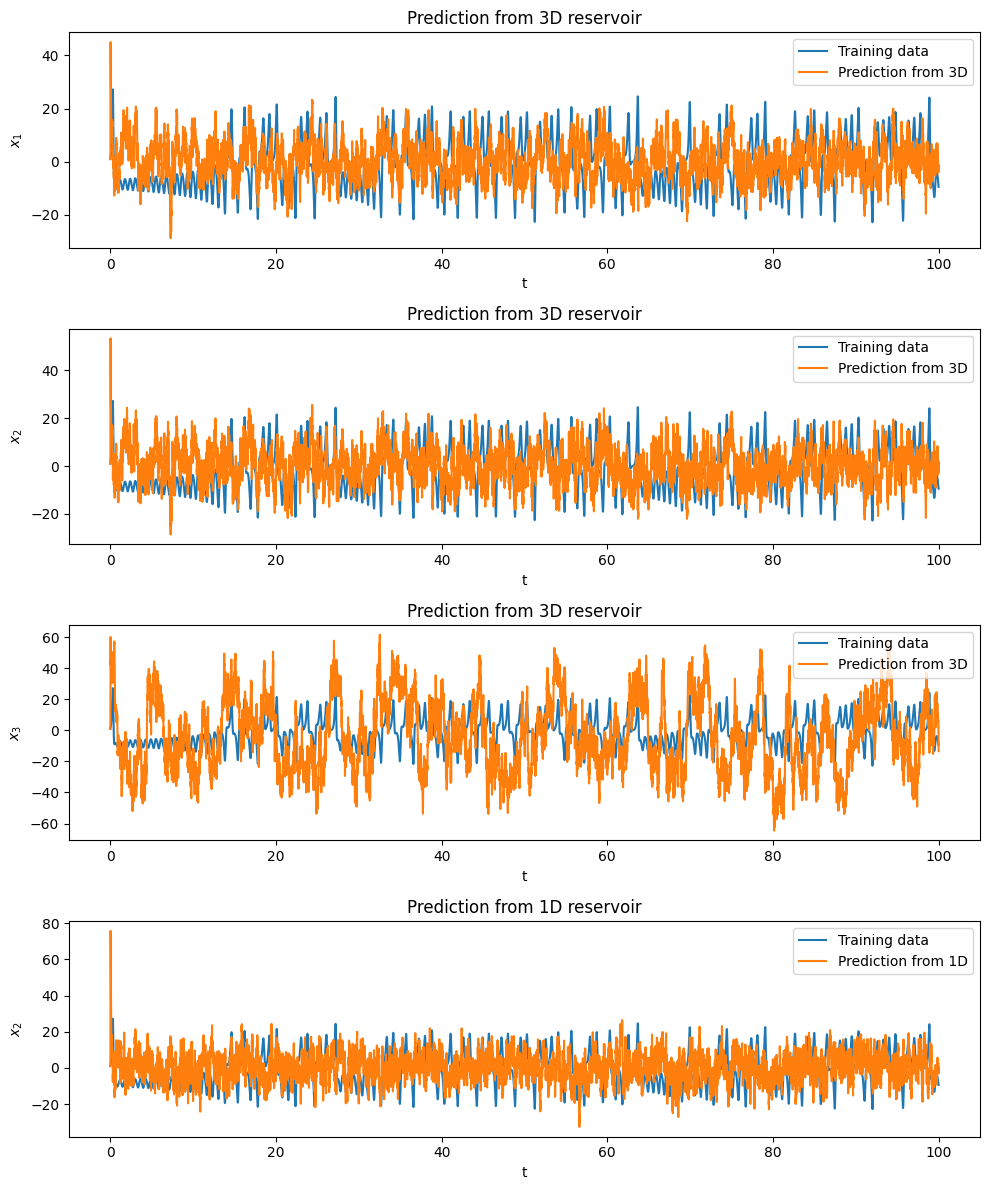

In [174]:
import matplotlib.pyplot as plt

t_span = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
t_shape = np.shape(t_span)

# Define figure and axes
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# Plot the training data in all subplots
for ax in axes:
    ax.plot(t_span, Y[1,:], label='Training data')

# Plot the predictions from the 3D reservoir in the first three subplots
for i, ax in enumerate(axes[:-1]):
    ax.plot(t_span, pred_3D[i,:], label='Prediction from 3D')
    ax.set_ylabel(fr'$x_{i+1}$')
    ax.set_xlabel('t')
    ax.set_title('Prediction from 3D reservoir')
    ax.legend()

# Plot the predictions from the 1D reservoir in the fourth subplot
axes[-1].plot(t_span, pred_1D.reshape(t_shape), label='Prediction from 1D')
axes[-1].set_ylabel(r'$x_2$')
axes[-1].set_xlabel('t')
axes[-1].set_title('Prediction from 1D reservoir')
axes[-1].legend()

# Show the figure
plt.tight_layout()
plt.show()


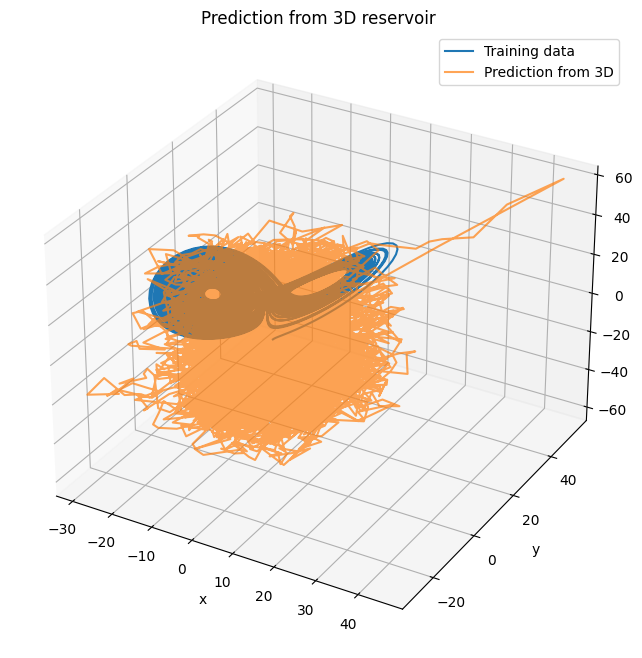

In [175]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the original data
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y[0, :], Y[1, :], Y[2, :], label='Training data')

# Plot the prediction from the 3D reservoir
ax.plot(pred_3D[0, :], pred_3D[1, :], pred_3D[2, :], label='Prediction from 3D', alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Prediction from 3D reservoir')
ax.legend()

# Show the plot
plt.show()

In [ ]:
def sv_n_error(isOneD):
    
    sigma = [10**i/10**(n_samples-sample_drift) for i in range(n_samples)]
    mse = np.zeros((n_samples,1))
    sing_val = np.zeros((n_samples,1))
    y = np.matrix(x_train[1,:])
    y_test = np.asarray(x_test[1,:])
    #Correct form on MSE for 3d???
    #Shorter test time series?
    for i in trange(n_samples):
        for j in range(monka):
            if isOneD:
                w_out, w_in, w_r, r0 = train_rnn(y, n_neurons, k_ridge, sigma[i])
            else:
                w_out, w_in, w_r, r0 = train_rnn(x_train, n_neurons, k_ridge, sigma[i])
            x_pred = rnn_predict(w_out, w_in, w_r, t_predict, r0)
            u, s, vh = np.linalg.svd(w_r)
            
            if isOneD:
                x_pred = np.reshape(x_pred,-1)
                mse[i] += MSE(y_test,x_pred)/monka
            else:
                mse[i] += MSE(np.transpose(x_test),np.transpose(x_pred))/monka
            sing_val[i] += max(s)/monka
    return sing_val, mse

## Jesper Code

In [25]:
from matplotlib import projections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
def generate_lorenz(dt,T,x0):
    x = np.zeros((3,T))
    x[:,0] = x0
    for t in range(T-1):
        x[0,t+1] = x[0,t] + dt*sigma*(x[1,t] - x[0,t])
        x[1,t+1] = x[1,t] + dt*(x[0,t]*(r - x[2,t]) - x[1,t])
        x[2,t+1] = x[2,t] + dt*(x[0,t]*x[1,t] - b*x[2,t])
    return x


def train_rnn(x: np.array([]),n_neurons: int, k_ridge: float, sigma: float):
    #Using linear regression (Least square) as training
    n_inputs = np.size(x,axis=0)
    t_train = np.size(x,axis=1)
    w_in = np.random.normal(0,np.sqrt(1/n_neurons),(n_neurons, n_inputs))
    w_r = np.random.normal(0,np.sqrt(sigma),(n_neurons, n_neurons))
    r = np.zeros((n_neurons,t_train))
    r0 = np.zeros((n_neurons,1))
    
    for t in range(t_train):
        arg1 = np.matmul(w_r,np.transpose(np.matrix(r[:,t])))
        arg2 = np.matmul(w_in,np.transpose(np.matrix(x[:,t])))
        if t == t_train-1:
            r0 = np.reshape(np.tanh(arg1 + arg2),-1)
        else:
            r[:,t+1] = np.reshape(np.tanh(arg1 + arg2),-1)
    matrix1 = np.matmul(x,np.transpose(r))
    matrix2 = np.linalg.inv(np.matmul(r,np.transpose(r)) + k_ridge*np.identity(n_neurons))
    w_out = np.matmul(matrix1,matrix2)
    return w_out, w_in, w_r, r0


def rnn_predict(w_out: np.array([]), w_in: np.array([]), w_r: np.array([]), t_predict: int, r0: np.array([])):
    n_inputs = np.size(w_in,axis=1)
    x_pred = np.zeros((n_inputs,t_predict))
    r = np.zeros((n_neurons,t_predict+1))
    r[:,0] = r0
    for t in range(t_predict):
        x_pred[:,t] = np.matmul(w_out,r[:,t])
        arg1 = np.matmul(w_r,np.transpose(np.matrix(r[:,t])))
        arg2 = np.matmul(w_in,np.transpose(np.matrix(x_pred[:,t])))
        r[:,t+1] = np.reshape(np.tanh(arg1 + arg2),-1)
    return x_pred

In [39]:
from tqdm import trange
def sv_n_error(isOneD):
    sigma = [10**i/10**(n_samples-sample_drift) for i in range(n_samples)]
    mse = np.zeros((n_samples,1))
    sing_val = np.zeros((n_samples,1))
    y = np.matrix(x_train[1,:])
    y_test = np.asarray(x_test[1,:])
    #Correct form on MSE for 3d???
    #Shorter test time series?
    for i in trange(n_samples):
        for j in range(monka):
            if isOneD:
                w_out, w_in, w_r, r0 = train_rnn(y, n_neurons, k_ridge, sigma[i])
            else:
                w_out, w_in, w_r, r0 = train_rnn(x_train, n_neurons, k_ridge, sigma[i])
            x_pred = rnn_predict(w_out, w_in, w_r, t_predict, r0)
            u, s, vh = np.linalg.svd(w_r)
            
            if isOneD:
                x_pred = np.reshape(x_pred,-1)
                mse[i] += MSE(y_test,x_pred)/monka
            else:
                mse[i] += MSE(np.transpose(x_test),np.transpose(x_pred))/monka
            sing_val[i] += max(s)/monka
    return sing_val, mse

In [27]:
def jacoby(x: np.array([])):
    return np.array([[-sigma, sigma, 0], [r-x[2],-1,-x[0]], [x[1],x[0],-b]])

def get_lupanov(x: np.array([])):
    lambdas = np.zeros((3,1))
    Q = np.identity(3)
    rango = range(500,T)
    for t in rango:
        M = np.identity(3) + jacoby(x[:,t]) * dt
        a = np.matmul(M,Q)
        Q, R = np.linalg.qr(a,mode='complete')
        for i in range(3):
            lambdas[i] += np.log(abs(R[i,i]))/(dt*len(rango))
    return lambdas

(3, 4250)
Lypanov exponents: [[ 9.16158976e-01]
 [-7.47140748e-03]
 [-1.48369097e+01]]


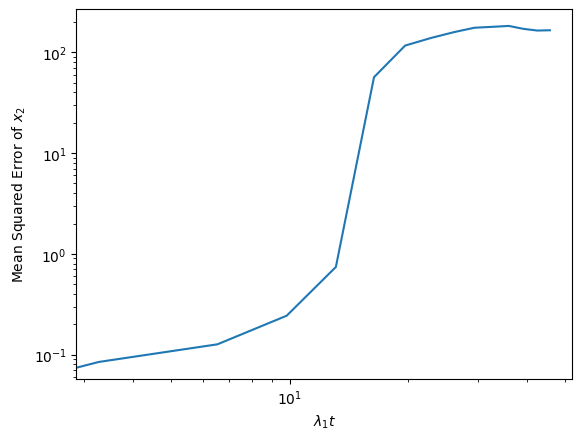

In [499]:
sigma = 10
r = 28
b = 8/3
dt = 0.01
k_ridge = 0.01
n_neurons = 500
n_samples = 30
T = 5000
T_train = int(0.85*T)
t_predict = T - T_train
monka = 10
sample_drift = 15
x0 = np.array([1,1,1])
x = generate_lorenz(dt,T,x0)
x_train = x[:,range(T_train)]
x_test = x[:,range(T_train,T)]
print(x_train.shape)

#4
lambdas = get_lupanov(x)
print(f'Lypanov exponents: {lambdas}')
lyp1 = lambdas[0]
y = np.matrix(x_train[1,:])
w_out, w_in, w_r, r0 = train_rnn(y, n_neurons, k_ridge,1/n_neurons)
x_pred_x2 = rnn_predict(w_out, w_in, w_r, t_predict, r0)
y_test = np.asarray(x_test[1,:])
x_pred_x2 = np.reshape(x_pred_x2,-1)
ind_bigus = int(t_predict/50)
mse = np.zeros(ind_bigus)
tot_time = lyp1*T*dt
t_scale = np.linspace(0,tot_time,ind_bigus)

for i in range(1,ind_bigus):
    mse[i] = MSE(y_test[range(i*50)], x_pred_x2[range(i*50)])
plt.figure()
plt.plot(t_scale, mse)
plt.xscale("log")
plt.yscale('log')
plt.xlabel(r'$\lambda_1 t$')
plt.ylabel(r'Mean Squared Error of $x_2$')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:28<00:00,  8.95s/it]


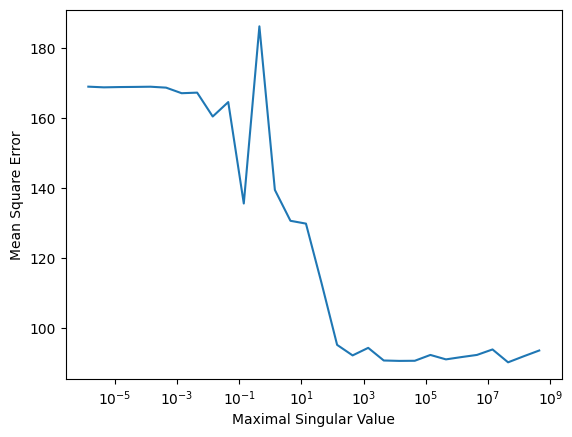

In [40]:
#3
sing_val, mse = sv_n_error(True)
plt.plot(sing_val,mse)
plt.xscale("log")
plt.xlabel('Maximal Singular Value')
plt.ylabel('Mean Square Error')
plt.show()